<h1>Efecto fotoeléctrico</h1>

<h2>Espectro de emisión del mercurio</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import speed_of_light, electron_volt
from scipy.signal import find_peaks
from scipy.odr import Model, Data, ODR
from cycler import cycler

plt.rcParams.update({
   "text.usetex": True,
   "font.family": "serif",
})

In [2]:
df = pd.read_csv("./Datos/espectro-mercurio-2nd.csv")
df['Corriente'] = df['Corriente'].apply(lambda x: 1e-8 * x) # Orden de magnitud correcto

wavelength = df["Longitud de onda"]
current = df["Corriente"]

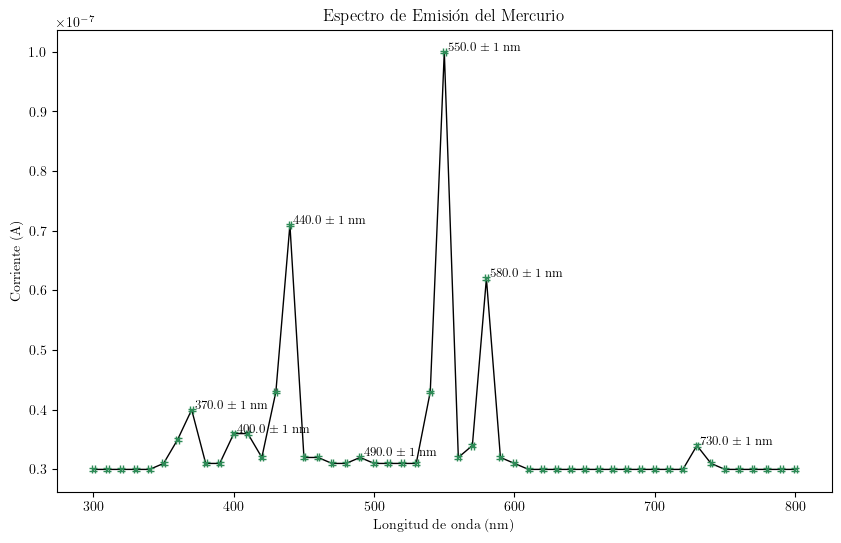

In [3]:
# Incertidumbres
error_current = 0.02e-8  # A (2e-10) Electrometro
error_wavelength = 1  # nm Monocromador

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wavelength, current, color='black', lw=1)

# Barras de error
ax.errorbar(wavelength, current, xerr=error_wavelength, yerr=error_current, capsize=3, fmt="o", c="seagreen", ms=0.5)

# Identificar y etiquetar los picos
peaks, _ = find_peaks(current)
for color, peak in enumerate(peaks):
    lambda_peak = wavelength[peak]
    ax.text(lambda_peak + 2.5, current[peak], f"${{{lambda_peak:.1f} \\pm {error_wavelength}}}$ nm", ha='left', va='bottom', fontsize=9, color='black')

ax.set_xlabel("Longitud de onda (nm)")
ax.set_ylabel("Corriente (A)")
ax.set_title("Espectro de Emisión del Mercurio")

fig.savefig("espectro-mercurio-err.png", dpi=1000)
plt.show()


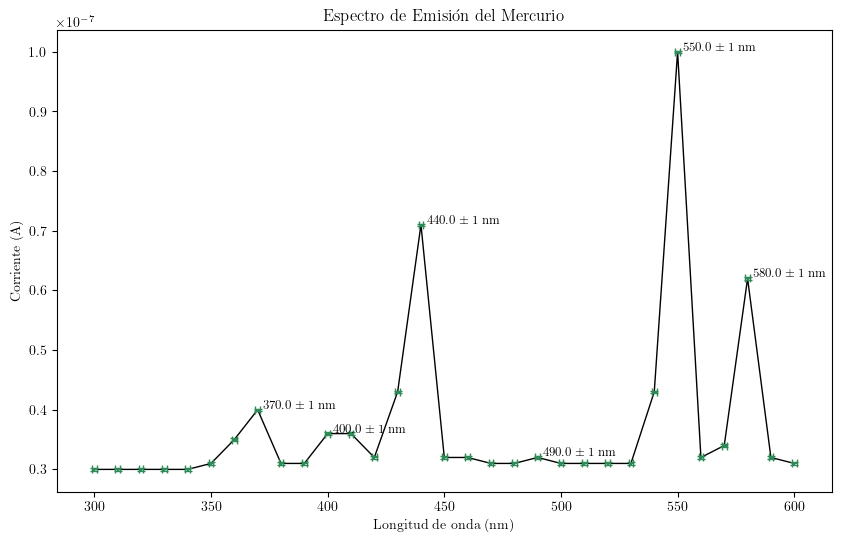

In [4]:
new_spectre = df.loc[df["Longitud de onda"] <= 600, ["Longitud de onda", "Corriente"]]
wavelength = new_spectre["Longitud de onda"]
current = new_spectre["Corriente"]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wavelength, current, color='black', lw=1)

# Barras de error
ax.errorbar(wavelength, current, xerr=error_wavelength, yerr=error_current, capsize=3, fmt="o", c="seagreen", ms=0.5)

# Identificar y etiquetar los picos
peaks, _ = find_peaks(current)
for color, peak in enumerate(peaks):
    lambda_peak = wavelength[peak]
    ax.text(lambda_peak + 2.5, current[peak], f"${{{lambda_peak:.1f} \\pm {error_wavelength}}}$ nm", ha='left', va='bottom', fontsize=9, color='black')

ax.set_xlabel("Longitud de onda (nm)")
ax.set_ylabel("Corriente (A)")
ax.set_title("Espectro de Emisión del Mercurio")

fig.savefig("espectro-mercurio.png", dpi=1000)
plt.show()

<h2>Gráfica $I$ vs $V$</h2>

In [5]:
def corriente_voltaje(archivo, marker):
    df = pd.read_csv(archivo)
    df["Corriente"] = df["Corriente"].apply(lambda x: 3e-8 * x) # Ajuste debido al multiplicador

    voltaje = df["Voltaje"]
    corriente = df["Corriente"]

    # Graficar datos
    ax.plot(voltaje, corriente, label=f"$\\lambda = ${archivo[8:11]} nm", marker=marker)
    ax.legend()

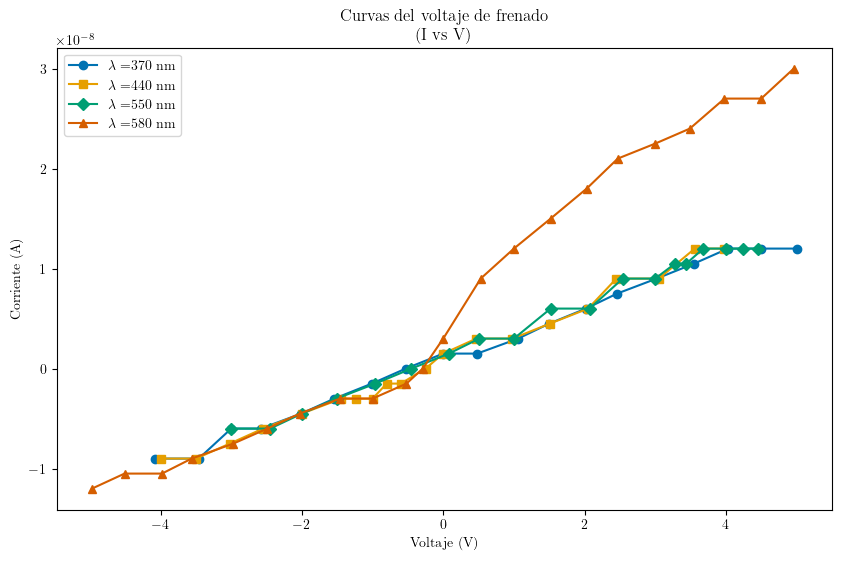

In [6]:
archivos = ["./Datos/370-wavelength.csv", "./Datos/440-wavelength.csv", "./Datos/550-wavelength.csv", "./Datos/580-wavelength.csv"]
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Curvas del voltaje de frenado\n (I vs V)")
ax.set_xlabel(f"Voltaje (V)")
ax.set_ylabel(f"Corriente (A)")

colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00']
markers = ['o', 's', 'D', '^']

ax.set_prop_cycle(color=colors)

for archivo, marker in zip(archivos, markers):
    corriente_voltaje(archivo, marker)

fig.savefig("corriente-voltaje.png", dpi=1000)

<h2>Gráfica $V_{0}$ vs $\nu$</h2>

<a href="https://docs.scipy.org/doc/scipy/reference/odr.html">Regresión de distancia ortogonal (ODR)</a>

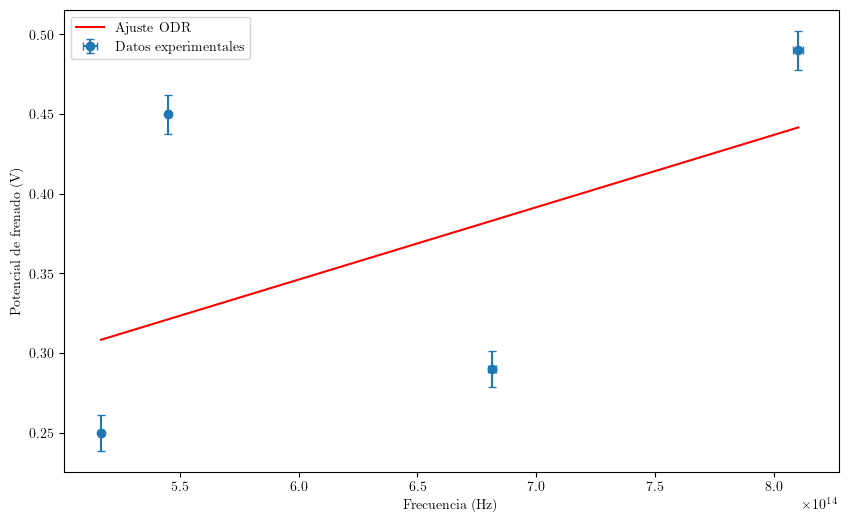

h/e = 4.543e-16 ± 5.373e-16 V·s
φ/e = 0.074 ± 0.346 V
El coeficiente de correlación es R^2 = 0.25466


In [7]:
stopping_potential = np.array([0.49, 0.29, 0.45, 0.25])
wavelengths = np.array([370, 440, 550, 580]) * 1e-9
frequencies = [speed_of_light / wl for wl in wavelengths]

sigma_wl = 1e-9 # Incertidumbre longitud de onda

# Dataframe
d={'Voltaje': stopping_potential, 'Frecuencia': frequencies}
volt_freq = pd.DataFrame(data=d) # Voltaje - Frecuencia
stopping_potential = volt_freq['Voltaje']
frequency = volt_freq['Frecuencia']

### Propagración de incertidumbres ###
# Frecuencia
sigma_nu = (speed_of_light / wavelengths ** 2) * sigma_wl
# Voltaje
sigma_v0 = 0.005 * stopping_potential + 0.01  # Para el rango de 20V. Resolución 10mV. Precisión \pm (5% + 1 dígito)

# Definir modelo lineal V0 = (h/e) * nu - (phi/e)
def linear_model(B, x):
    return B[0] * x + B[1]

# Crear objeto modelo
linear = Model(linear_model)

# Crear datos para ODR
data = Data(frequency, stopping_potential, wd=1/sigma_nu**2, we=1/sigma_v0**2)

# Configurar ODR con valores iniciales aproximados
odr = ODR(data, linear, beta0=[4.14e-15, -0.5])

# Ejecutar ajuste
output = odr.run()

# Extraer parámetros y sus incertidumbres
h_e, phi_e = output.beta  # Pendiente y ordenada
sigma_h_e, sigma_phi_e = output.sd_beta  # Incertidumbres en los parámetros

# Calcular valores ajustados
volt_freq["v0_pred"] = h_e * volt_freq["Frecuencia"] + phi_e

# Calcular R^2
SS_res = np.sum((volt_freq["Voltaje"] - volt_freq["v0_pred"]) ** 2)  # Suma de los residuos al cuadrado
SS_tot = np.sum((volt_freq["Voltaje"] - np.mean(volt_freq["Voltaje"])) ** 2)  # Suma total de cuadrados
R2 = 1 - (SS_res / SS_tot)

# Graficar ajuste
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(frequency, stopping_potential, xerr=sigma_nu, yerr=sigma_v0, fmt='o', label="Datos experimentales", capsize=3)
x_fit = np.linspace(min(frequency), max(frequency), 100)
ax.plot(x_fit, h_e * x_fit + phi_e, label="Ajuste ODR", color='red')
ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("Potencial de frenado (V)")
ax.legend()
fig.savefig("potencial-frecencia.png", dpi=1000)
plt.show()

# Imprimir resultados
print(f"h/e = {h_e:.3e} ± {sigma_h_e:.3e} V·s")
print(f"φ/e = {phi_e:.3f} ± {sigma_phi_e:.3f} V")
print(f"El coeficiente de correlación es R^2 = {R2:.5f}")


In [8]:
print(f"h = {h_e * electron_volt:.3e} ± {sigma_h_e * electron_volt:.3e} J·s")
print(f"φ = {phi_e * electron_volt:.3e} ± {sigma_phi_e * electron_volt:.3e} eV")

h = 7.279e-35 ± 8.608e-35 J·s
φ = 1.178e-20 ± 5.539e-20 eV


In [9]:
from scipy.constants import physical_constants

print(f"La medición presenta un error del {int((np.abs((h_e * electron_volt) - physical_constants["Planck constant"][0]) / physical_constants["Planck constant"][0]) * 100)}% respecto al valor aceptado")

La medición presenta un error del 89% respecto al valor aceptado
